##**Digit classification using HOG features**

## **Introduction:**<br>
Object classification is an important task in many computer vision applications, including surveillance, automotive safety, and image retrieval. For example, in an automotive safety application, you may need to classify nearby objects as pedestrians or vehicles. Regardless of the type of object being classified, the basic procedure for creating an object classifier is:

- Acquire a labeled data set with images of the desired object.
- Partition the data set into a training set and a test set.
- Train the classifier using features extracted from the training set.
- Test the classifier using features extracted from the test set

## **Objective**<br>
In this lab you will learn how to classify numerical digits using HOG (Histogram of Oriented Gradient) features and several multiclass classifiers, and compare the performance measures.

The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. 

Download the data set of handwritten images at this link http://yann.lecun.com/exdb/mnist/

Following files contain training and test images
- [train-images-idx3-ubyte.gz](http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz):  training set images (9912422 bytes) 
- [train-labels-idx1-ubyte.gz](http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz):  training set labels (28881 bytes) 
- [t10k-images-idx3-ubyte.gz](http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz):   test set images (1648877 bytes) 
- [t10k-labels-idx1-ubyte.gz](http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz):   test set labels (4542 bytes)


## **Tasks:**<br>
1.	Get the MNIST dataset of handwritten digits.
2.	For each handwritten digit in the database, extract HOG features and train a Linear SVM.
3.	Use the classifier trained in step 2 to predict digits.



## **Dependencies**

Following are the package required for using this notebook
- numpy
- tqdm
- opencv-python
- matplotlib
- scikit-image
- pandas


## **Downloading data** <br>
1. In your local system, you can manually downlaod all the train and test files and place in the "Dataset" folder.
2. You can also work in colab and use following commands to download data files. (Alternatively, you can store your files in Google Drive and read it from there). 

In [1]:
import numpy as np
import gzip
import struct
import cv2
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# make directory
!mkdir Dataset
# change directory
%cd Dataset/

#download files in Dataset folder
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

#go back to previous directory
%cd ..

/content/Dataset
--2020-12-01 14:00:51--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 172.67.171.76, 104.28.7.204, 104.28.6.204, ...
Connecting to yann.lecun.com (yann.lecun.com)|172.67.171.76|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  59.1MB/s    in 0.2s    

2020-12-01 14:00:51 (59.1 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2020-12-01 14:00:51--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 172.67.171.76, 104.28.7.204, 104.28.6.204, ...
Connecting to yann.lecun.com (yann.lecun.com)|172.67.171.76|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘train-labels-idx1-ubyte.gz’

train-labels-idx1-u 100%[==================

## **Load Data**<br>
Below is the helper function to load MNIST digit classification dataset.

In [3]:
def read_data(label, image):
  with gzip.open(label, 'rb') as flbl:
    magic, num = struct.unpack(">II", flbl.read(8))
    label = np.frombuffer (flbl.read(), dtype=np.int8)
  with gzip.open(image, 'rb') as fimg:
    magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
    image = np.frombuffer (fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)
  return (label, image)

In [4]:
(train_lbl, train_img) = read_data(r'./Dataset/train-labels-idx1-ubyte.gz', 
                                   r'./Dataset/train-images-idx3-ubyte.gz')
(test_lbl, test_img) = read_data(r'./Dataset/t10k-labels-idx1-ubyte.gz', 
                                   r'./Dataset/t10k-images-idx3-ubyte.gz')

print("Training Samples : " +  str(len(train_img)))
print("Test Samples : " +  str(len(test_img)))
train_img[0].shape

print(train_lbl)
print(test_lbl)

Training Samples : 60000
Test Samples : 10000
[5 0 4 ... 5 6 8]
[7 2 1 ... 4 5 6]


**Visualize Dataset**:

Lets print some of the training and test images along with their respective labels for verification

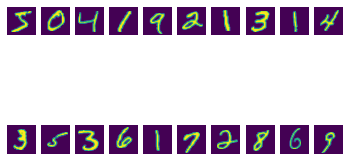

Training label: [5 0 4 1 9 2 1 3 1 4]
Training label: [3 5 3 6 1 7 2 8 6 9]


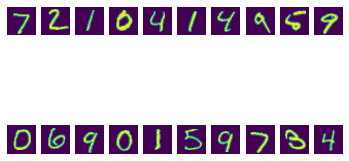

Test label: [7 2 1 0 4 1 4 9 5 9]
Testlabel: [0 6 9 0 1 5 9 7 3 4]


In [5]:
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(train_img[i])
    plt.axis('off')
plt.show()
print('Training label: %s' % (train_lbl[0:10],))
print('Training label: %s' % (train_lbl[10:20],))

for i in range(20):  
    plt.subplot(2,10,i+1)
    plt.imshow(test_img[i])
    plt.axis('off')
plt.show()
print('Test label: %s' % (test_lbl[0:10],))
print('Testlabel: %s' % (test_lbl[10:20],))

**Computing HoG features**<br>
- Load the 'train_img_count' training images
- Loop through the images to Compute HOG features for each of the digit image
- Get the respective labels

Python library skimage is used to compute the HOG features. Have a look at the documentation of function features.hog here (https://kite.com/python/docs/skimage.feature.hog)

A number of feature detectors implementation is availabe in this package. The documentation can be seen here (https://scikit-image.org/docs/dev/api/skimage.feature.html)

In [6]:
from skimage import feature
from skimage import exposure
from tqdm.notebook import tqdm

#initialize list that contains training images
train_data = []
# count of all training images to use in loop
train_img_count = len(train_lbl)

def compute_HOG(image):
  (H1, hogImage1) = feature.hog(image, orientations = 3,
                                pixels_per_cell  = (2, 2), cells_per_block  = (2, 2), transform_sqrt=True,
                                block_norm  = 'L1' , visualize=True)
  return (H1, hogImage1)

# loop over the images
for i in tqdm(range(0,train_img_count)):
  # pre-process image here if needed
  # Computing the HOG features. Also Keep and eye on the parameters used in this function call.
  (h_vector, h_image) = compute_HOG(train_img[i])
  #append computed HOGs in train data
  train_data.append(h_vector)

#get train labels
train_label = train_lbl[0:train_img_count]

**Visualize an example of computed HOG**

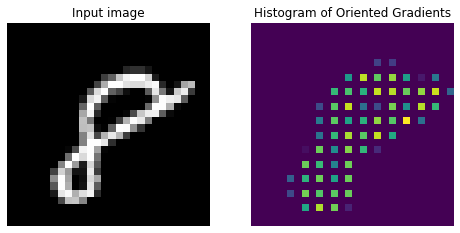

Length of computed vector
 2028


In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(train_img[i], cmap=plt.cm.gray) #i==499
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(h_image, in_range=(0, 255))

ax2.axis('off')
ax2.imshow(hog_image_rescaled)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

# length of computed feature vector
print("Length of computed vector\n",len(h_vector))

**Training**

In [8]:
#train_data --> contains vector histogram of train images
#train_labels --> contains labels of train images
#test_data --> contains histogram of test images
#test_label --> contains labels of test

from sklearn.svm import LinearSVC

# load linear SVM
modelSVC = LinearSVC(max_iter=3000)
modelSVC.fit(train_data, train_label)
print("SVC training completed")

SVC training completed


**Testing**
<br>
Lets prepare testing data before evaluations and predictions

In [9]:
from tqdm.notebook import tqdm
test_data = []
test_img_count = len(test_img)

# loop over the images
for i in tqdm(range(test_img_count)):
  # pre-process image here if needed
  # Computing the HOG features. Also Keep and eye on the parameters used in this function call.
  (h_vector, h_image) = compute_HOG(test_img[i])
  #append computed HOGs in train data
  test_data.append(h_vector)

#get labels
test_labels = test_lbl[0:test_img_count]

In [10]:
# Create predictions
predicted_labels = modelSVC.predict(test_data)
print("Prediction completed")
# uncomment below lines to get the predicted labesl and the actural labels printed.
print("Comparing predicted and actual labels")
print(predicted_labels[0:10])
print(test_labels[0:10])

Prediction completed
Comparing predicted and actual labels
[7 2 1 0 4 1 4 9 5 9]
[7 2 1 0 4 1 4 9 5 9]


**Computing performance measures**<br>
ConfusionMatrix from pandas_ml python library/package is used to evaluate the performance of digit classification task. Documentation can be seen here (https://pandas-ml.readthedocs.io/en/latest/conf_mat.html)

In [11]:
mask = predicted_labels==test_labels
correct = np.count_nonzero(mask)
print (correct*100.0/predicted_labels.size)
result = predicted_labels.astype(int)

97.86


**Confusion Matrix**<br>
A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data

We will use pandas package for creating confusion Matrix

In [12]:
import pandas as pd
act = pd.Series(test_labels,name='Actual')
pred = pd.Series(predicted_labels,name='Predicted')
confusion_matrix = pd.crosstab(act, pred,margins=True)
print("Confusion matrix:\n%s" % confusion_matrix)

Confusion matrix:
Predicted    0     1     2     3    4    5    6     7    8     9    All
Actual                                                                 
0          973     0     1     0    0    1    3     0    2     0    980
1            0  1125     3     2    0    0    1     1    3     0   1135
2            4     4  1008     3    0    0    2     7    4     0   1032
3            1     0     1   986    0    9    0     5    7     1   1010
4            1     0     0     1  955    0    4     2    3    16    982
5            2     0     1     6    0  874    2     1    5     1    892
6            2     3     0     0    1    2  946     0    3     1    958
7            0     2     9     3    2    1    0  1003    1     7   1028
8            3     0     4     3    5    2    2     4  945     6    974
9            4     3     2     4    9    2    1     8    5   971   1009
All        990  1137  1029  1008  972  891  961  1031  978  1003  10000


Plotting above created Confusion Matrix

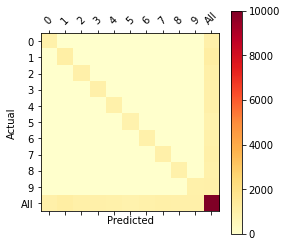

In [13]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.YlOrRd):
  plt.matshow(df_confusion, cmap=cmap) # imshow
  plt.colorbar()
  tick_marks = np.arange(len(df_confusion.columns))
  plt.xticks(tick_marks, df_confusion.columns, rotation=45)
  plt.yticks(tick_marks, df_confusion.index)
  plt.ylabel(df_confusion.index.name)
  plt.xlabel(df_confusion.columns.name)
#call function
plot_confusion_matrix(confusion_matrix)

**Classification Report**<br>
Build a text report showing the main classification metrics.<br>More on https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

In [14]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, predicted_labels, target_names=["0","1","2","3","4","5","6","7","8","9"]))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.97      0.98       982
           5       0.98      0.98      0.98       892
           6       0.98      0.99      0.99       958
           7       0.97      0.98      0.97      1028
           8       0.97      0.97      0.97       974
           9       0.97      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



Classifying a single example

Actual Label =
9
Predicted Label =
9


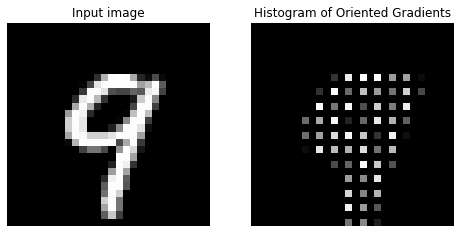

In [15]:
# set index out of 10000 test images
index = 12
#get image
image = test_img[index]

#compute hog feature vector for above image
(h_vector, h_image) = compute_HOG(image)
obtained_label = modelSVC.predict([h_vector])

#comparison
print("Actual Label =")
print(test_labels[index])
print("Predicted Label =")
print(obtained_label[0])

#visualize
figr, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(image, cmap="gray")
ax1.set_title('Input image')
ax2.axis('off')
ax2.imshow(h_image,cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

